$$\Large{\textbf{Subreddit Classifier}}$$ 

$$_______________________________________________________________________________________________$$


The following code extracts text data from various forums on Reddit.com and trains a classifier to read and predict the subreddit a post belongs to.

This is achieved using various Natural Language Processing techniques; 
 - tokenizing/lemmatizing the data
 - vectorizing each post
 - finding a low-rank approximation to the term-document matrix

 
I make an attempt to balance mathematical formalism and common english in describing this process.




In [1]:
# Chose our list of subreddits to train our classifier on
subreddits = ['biology','physics','chemistry','mathematics',\
              'machinelearning','cscareerquestions','datascience',\
              'standup']

# Reddit's Python API Wrapper
import praw

# Load in data
reddit = praw.Reddit(client_id='my_id',client_secret='my_secret',user_agent = 'my_agent')    

$$\text{We create a list of character strings corresponding to each post, and label them by subreddit}$$

In [2]:
import pandas as pd
import re

# Instantiate lists
all_posts , sub_labels = list(), list()

# Loop over list of subreddits
for i, sub in enumerate(subreddits):
    
    # Get text from 25000 latest posts
    subreddit_data = reddit.subreddit( sub ).new( limit = 25000 )
    
    # Limit to those at least 80 alphabetic characters
    posts = [post.selftext for post in subreddit_data if len(re.sub('\W|\d', '', post.selftext)) >= 80]

    # Add posts/labels to respective lists
    all_posts += posts
    sub_labels += [i] * len(posts) 
    
    # Print after success
    print("number of posts from {}: ".format(sub),len(posts)) 


number of posts from biology:  511
number of posts from physics:  222
number of posts from chemistry:  543
number of posts from mathematics:  821
number of posts from machinelearning:  885
number of posts from cscareerquestions:  976
number of posts from datascience:  746
number of posts from standup:  739


$$\text{Visually analyze how the posts are distributed:}$$

In [3]:
# Pyplot for data visualization (import in a seperate cell from plot to display)
import matplotlib.pyplot as plt
import numpy as np

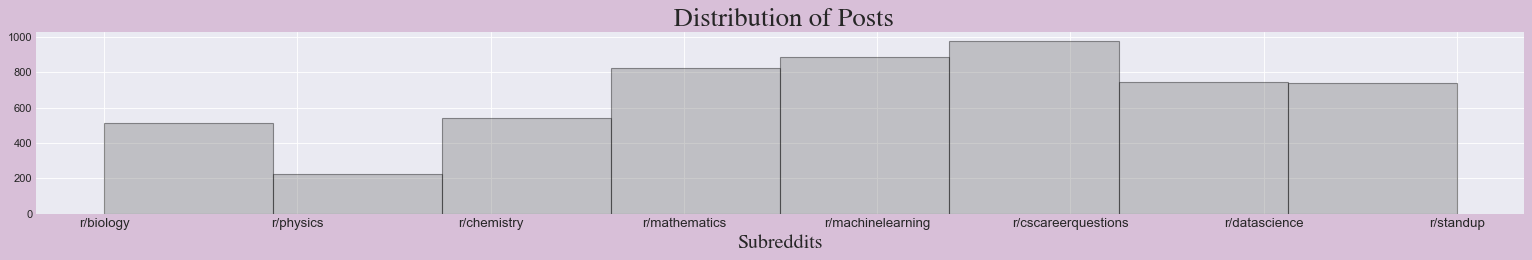

In [4]:
# Select desired style for our plot
plt.style.use('seaborn-darkgrid')

# Set figure specifications
plt.figure(figsize = (3*len(subreddits),3), dpi=80, facecolor='thistle')
# Set Title
plt.title(" Distribution of Posts", size = 24, style = 'italic',  fontname='Times')
# Set xlabel
plt.xlabel("Subreddits", size=18,  fontname='Times')
# Set tick labels
plt.xticks(range(len(subreddits)), labels=["r/{}".format(sub) for sub in subreddits], size=12) 
# Plot the histogram
plt.hist(np.array(sub_labels), bins = len(subreddits),color='grey', alpha = 0.4, edgecolor='k') 

plt.show() 

$$\text{Defining custom preprocessing functions}$$

We clean our text data in the following ways:
- Break the post into individual words, removing not alphabetic characters and URL-like strings
- Lemmatize the words so we weight the same concepts equally ("playing" = "plays" = "played")
- Remove 1-letter words and 'stop words' that do not convey meaning in the text ("i", "a", "be", "in")

In [5]:
# Natural Language Tool Kit and several preprocessing methods
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords


# Remove all non alphabetic characters, or URL-like patterns
def my_preprocessor(doc):
    return re.sub('\W|\d|http\S+|www\S+',' ',doc)


# Break our post into tokens then lemmatize
def my_tokenizer(text):
    tokens = [word.lower() for word in nltk.word_tokenize(text) \
              if word not in stopwords.words('english') and len(word)>1]
    lemmas = [WordNetLemmatizer().lemmatize(token) for token in tokens]
    return lemmas


# Comparing raw text data from reddit post to list of tokens
print("BEFORE: \n{} ...".format(re.sub('\n','  ',all_posts[0])),\
      "\n\nAFTER: \n",my_tokenizer(my_preprocessor(all_posts[0])))

BEFORE: 
Does the brain have to signal every individual cell to do a specific movement or does the brain just have to send it to the specific muscle? Like how does the brain see the rest of its body when trying to do something? ... 

AFTER: 
 ['doe', 'brain', 'signal', 'every', 'individual', 'cell', 'specific', 'movement', 'brain', 'send', 'specific', 'muscle', 'like', 'brain', 'see', 'rest', 'body', 'trying', 'something']


$$\Large{\text{Vectorizing the text data}}$$

Now that each post is a list of meaningful words, the data can be represented by a term-document matrix. 

Let $\mathbf{v_i}$ be the i'th document in our corpus, and $\mathbf{w_j}$ be the j'th word to appear in our text data.

We can then construct a matrix $\mathbf{X}$, where element $x_{i,j}$ corresponds to the frequency of term $i$ in submission $j$. 

$$\mathbf{X} = 
\begin{bmatrix}
x_{1,1} & \cdots &
x_{1,n} \\
\vdots & \ddots & \vdots \\
x_{m,1} & \cdots &
x_{m,n}
\end{bmatrix}$$


The words are weighted using a "term-frequency, inverse-document-frequency" scale. 

This ensures that each document's words positively correlate to the frequency of occurance in the document, but inversely correlates to how frequently the word appears in the entire corpus.

In [6]:
# Use Tfidf to vectorize posts
from sklearn.feature_extraction.text import TfidfVectorizer

# Use our predefined functions to clean the data
vectorizer = TfidfVectorizer(preprocessor = my_preprocessor, \
                             tokenizer = my_tokenizer, \
                             min_df = 1)

# Our term-document matrix
X = vectorizer.fit_transform(all_posts)

# The transpose (document-term matrix)
X_transpose =  np.transpose(X) 

In [7]:
X

<5443x19572 sparse matrix of type '<class 'numpy.float64'>'
	with 266299 stored elements in Compressed Sparse Row format>

Above, we see our matrix $\mathbf{X}$ is huge and sparsely populated, in order to better cluster our posts we seek to find a low rank approximation.


In [8]:
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD

tsvd = TruncatedSVD(n_components = 100, n_iter = 10)
X_reduced = tsvd.fit_transform(csr_matrix(X).toarray())


Splitting the data into training and validation sets:

In [9]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
xtr, xte, ytr, yte = train_test_split(X_reduced, np.array(sub_labels), test_size = .2, random_state = 1)


$$\text{Decision Tree Classifier}$$

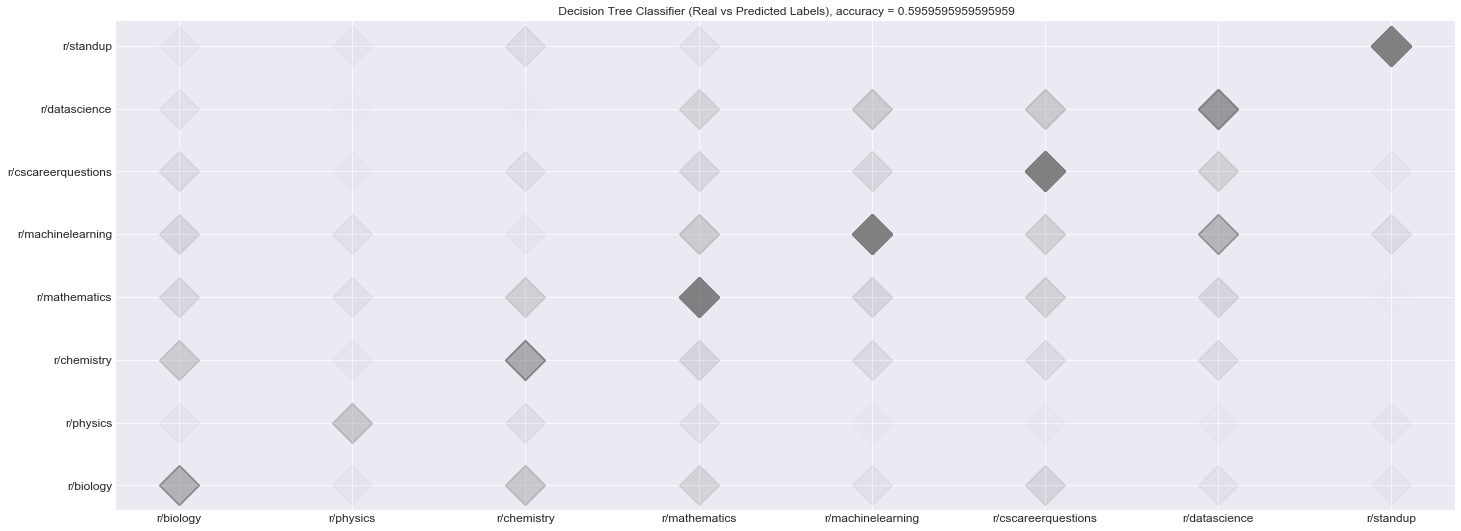

In [10]:
from sklearn.tree import DecisionTreeClassifier

# Fit the model to our training data, and make predictions on the validation set
dtc = DecisionTreeClassifier().fit(xtr, ytr)
predict = dtc.predict(xte)

# Measure the accuracy of our model
from sklearn.metrics import accuracy_score
acc = accuracy_score(predict, yte)

# Plot the predictions as a function of true label
plt.figure(figsize = (3*len(subreddits), len(subreddits)+1))
plt.title(" Decision Tree Classifier (Real vs Predicted Labels), accuracy = {}".format(acc))
plt.scatter(yte, predict, alpha = 0.01, s = 800, marker = 'D', c='grey')
plt.xticks(range(len(subreddits)), labels=["r/{}".format(sub) for sub in subreddits], size=12) 
plt.yticks(range(len(subreddits)), labels=["r/{}".format(sub) for sub in subreddits], size=12) 

plt.show()
